In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

import json

from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 1


In [7]:
# Data loading
def data_to_df(job_run, samp_num):
    file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{job_run}/dataJob1ifile{samp_num}.root'
    data_file = uproot.open(file_name)
    data_array = data_file['tree'].arrays()
    data_df = pd.DataFrame(data_array)
    return data_df

def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [8]:
# Good luminosity functions

def convert_json_txt_to_dict(file_name):
    with open(file_name) as file:
        data = file.read()
    return json.loads(data)

def good_lumi_list(data_df, good_lumi_dict):
    good_lumis = []
    for index, row in data_df.iterrows():
        run = row[b'run']
        lumi = row[b'lumi']
        good_lumi = 0
        if str(int(run)) in good_lumi_dict:
            lumi_blocks = good_lumi_dict[str(int(run))]
            for lumi_block in lumi_blocks:
                if lumi_block[0] <= lumi and lumi <= lumi_block[1]:
                    good_lumi = 1
                    break
        good_lumis.append(good_lumi)
    return good_lumis

In [9]:
# Get good luminosity dictionaries

Good_Lum_2018 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt')
Good_Lum_2017 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_294927-306462_13TeV_EOY2017ReReco_Collisions17_JSON_v1.txt')
Good_Lum_2016 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_271036-284044_13TeV_ReReco_07Aug2017_Collisions16_JSON.txt')

In [10]:
data_2018_full_dfs = []
for i in range(190):
    data_2018_full_dfs.append(data_to_df('job_1_ntuple20180819v1', i))
data_2018_full_df = pd.concat(data_2018_full_dfs, ignore_index=True)

data_2017_full_dfs = []
for i in range(53):
    data_2017_full_dfs.append(data_to_df('job_1_ntuple20170819v1', i))
data_2017_full_df = pd.concat(data_2017_full_dfs, ignore_index=True)


# good lumi
data_2018_full_df[b'good_lumi'] = good_lumi_list(data_2018_full_df, Good_Lum_2018)
data_2018_good_df = data_2018_full_df[data_2018_full_df[b'good_lumi'] == 1]

data_2017_full_df[b'good_lumi'] = good_lumi_list(data_2017_full_df, Good_Lum_2017)
data_2017_good_df = data_2017_full_df[data_2017_full_df[b'good_lumi'] == 1]

data_good_dfs = [data_2017_good_df, data_2018_good_df]


In [11]:
data_dfs_ggHH = []
for y in range(len(data_good_dfs)):
    df_ggHH = data_good_dfs[y][data_good_dfs[y][b'ggHH_recon'] == 1].drop(columns = [b'good_lumi'])
    data_full_df_1 = df_ggHH[df_ggHH[b'diphoton_mass']>135]
    data_full_df_2 = df_ggHH[df_ggHH[b'diphoton_mass']<115]
    data_full_df_wind = pd.concat([data_full_df_1, data_full_df_2], ignore_index=True)
    data_dfs_ggHH.append(data_full_df_wind)

In [12]:
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)

In [13]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass_corr', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [14]:
i = 0

year = [2017, 2018]

bkg_frame_all = data_dfs_ggHH[i]


sig_frame_all = GluGluToHH_df

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[training_vars]
bkg_frame = bkg_frame_all[training_vars]


sig_df = sig_frame_all[training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[w_var]
bkg_weight = bkg_frame_all[w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [15]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [16]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [17]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    x_full_test = data_full[test_index] # full df test portion

TRAIN: [     0      1      2 ... 221131 221132 221133] TEST: [    15     18     24 ... 221117 221124 221130]
TRAIN: [     0      6      9 ... 221130 221131 221133] TEST: [     1      2      3 ... 221125 221126 221132]
TRAIN: [     0      1      2 ... 221130 221132 221133] TEST: [     6     19     20 ... 221128 221129 221131]
TRAIN: [     0      1      2 ... 221130 221131 221132] TEST: [    12     13     26 ... 221105 221120 221133]
TRAIN: [     1      2      3 ... 221131 221132 221133] TEST: [     0      9     10 ... 221119 221122 221127]


In [18]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_test == 1]
bgd_test_weights = test_weight[y_test == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

(176908, 27)
(176908,)
(44226, 27)
(44226,)


In [19]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax'], name = 'activation_func'),
          Real(10**-5, 10**0, "log-uniform", name='lr')
         ]


def DNN_model(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.0001):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

    
@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    model_tmp = DNN_model(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
    print (model_tmp)
    model_tmp.fit(x_train, y_train, epochs = 50, verbose = 1, validation_split = 0.2,  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/optimize/combine_opt_mass_model.h5', verbose=0)])
    
    y_train_tmp = model_tmp.predict(x_train)
    predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
    train_accuracy = accuracy_score(y_train, predictions_train_tmp)
    print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
    y_pred_tmp = model_tmp.predict(x_test)
    predictions_tmp = [round(value[0]) for value in y_pred_tmp]
    accuracy = accuracy_score(y_test, predictions_tmp)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    return -accuracy

In [20]:
# res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# print("Best parameters: {}".format(res_gp.x))
# best_n_hidden = res_gp.x[0]
# best_first_neuron = res_gp.x[1]
# best_n_neurons = res_gp.x[2]
# best_dropout_rate = res_gp.x[3]

In [21]:
# best_n_hidden = res_gp.x[0]
# best_first_neuron = res_gp.x[1]
# best_n_neurons = res_gp.x[2]
# best_dropout_rate = res_gp.x[3]
# best_activation = res_gp.x[4]
# best_learning_rate = res_gp.x[5]

# model = DNN_model(best_n_hidden, best_first_neuron, best_n_neurons, best_dropout_rate, best_activation, best_learning_rate)

# #https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
#                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
#                             ModelCheckpoint(filepath='Models/optimize/combine_out_opt_mass_model.h5', verbose=0)])
#                  #lass_weight={0:10,1:1})

In [22]:
model = DNN_model(3, 125, 125, 0.01, 'sigmoid', 0.00002)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath=f'Models/data/data_model_{year[i]}.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
944/944 [==============================] - 2s 2ms/step - loss: 0.4955 - accuracy: 0.7983 - val_loss: 1.3986 - val_accuracy: 0.0000e+00
Epoch 2/50
944/944 [==============================] - 2s 2ms/step - loss: 0.3296 - accuracy: 0.8539 - val_loss: 0.6561 - val_accuracy: 0.7234
Epoch 3/50
944/944 [==============================] - 2s 2ms/step - loss: 0.2003 - accuracy: 0.9299 - val_loss: 0.5430 - val_accuracy: 0.7940
Epoch 4/50
944/944 [==============================] - 2s 2ms/step - loss: 0.1854 - accuracy: 0.9321 - val_loss: 0.4987 - val_accuracy: 0.8126
Epoch 5/50
944/944 [==============================] - 2s 2ms/step - loss: 0.1792 - accuracy: 0.9334 - val_loss: 0.4886 - val_accuracy: 0.8180
Epoch 6/50
944/944 [==============================] - 2s 2ms/step - loss: 0.1749 - accuracy: 0.9345 - val_loss: 0.4769 - val_accuracy: 0.8227
Epoch 7/50
944/944 [==============================] - 2s 2ms/step - loss: 0.1718 - accuracy: 0.9351 - val_loss: 0.4724 - val_accuracy: 0.8262
Ep

2021-09-16 15:59:11.337963: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-16 15:59:11.361822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.2155GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2021-09-16 15:59:11.361860: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-09-16 15:59:11.364332: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-16 15:59:11.366319: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-09-16 15:59:11.366657: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libc

In [23]:
# Accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 91.80%
Accuracy: 91.75%


In [24]:
train_weight.shape

(176908, 1)

In [25]:
train_weight.ravel().shape

(176908,)

In [26]:
#Weigbted

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp, sample_weight = train_weight.ravel())
print("Weighted Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp, sample_weight = test_weight.ravel())
print("Weighted Accuracy: %.2f%%" % (accuracy * 100.0))

Weighted Training Accuracy: 83.13%
Weighted Accuracy: 82.97%


In [27]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

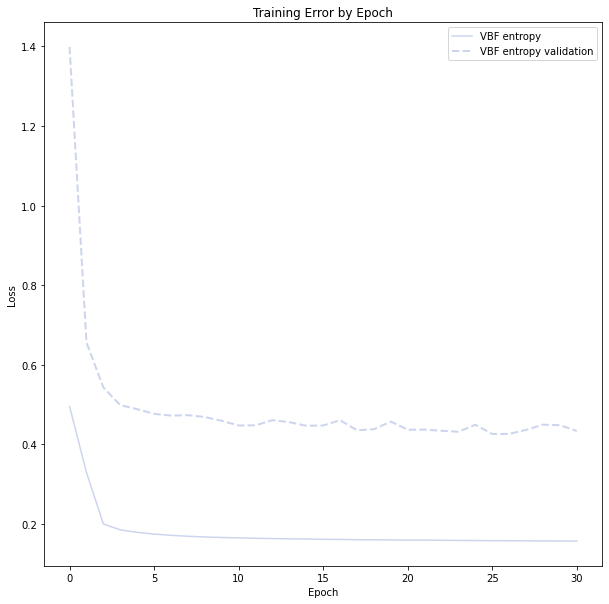

In [28]:
show_losses( [("VBF entropy", hist)])

In [29]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [30]:
from sklearn.metrics import roc_auc_score
auc_keras = roc_auc_score(y_test, y_pred)

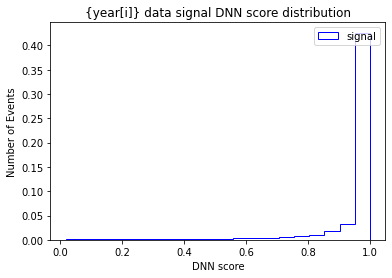

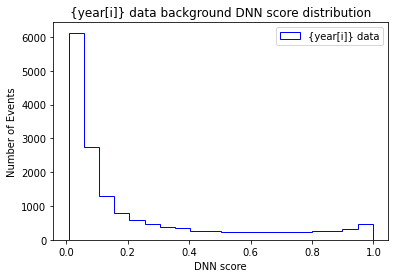

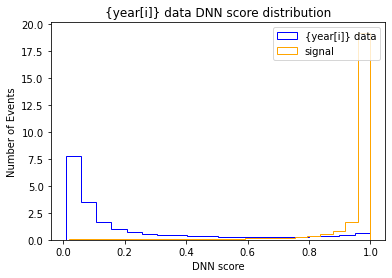

In [31]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title('{year[i]} data signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_{year[i]}_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= '{year[i]} data')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('{year[i]} data background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_{year[i]}_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= '{year[i]} data', density = True)
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 24, label= 'signal', density = True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title('{year[i]} data DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_{year[i]}_score.png', format='png')
plt.show()

In [32]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'genweight_scale'] = result_sig_df.loc[:, b'genweight'].values * scale_sig
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'genweight_scale'] = result_bgd_df.loc[:, b'genweight'].values * scale_bgd
result_bgd_df[b'DNN score'] = bgd_y

In [33]:
# Make copy of dataframe

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values

In [34]:
def check_mass_gg_samp(label, test_all, var_index, weight_index, dnn_index, label_index, samp_index, samp):
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    samp_test_all = test_all[test_all[:, samp_index]==samp]
    plt.figure(figsize=(9,6))
    plt.hist(samp_test_all[:,var_index][samp_test_alll[:,label_index]==label], bins=bins, weights=samp_test_all[:,weight_index][samp_test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = samp_test_all[np.where((samp_test_all[:,label_index]==label)*(samp_test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_gg_mass_sculpt_{samples[label]}_1')
    
def check_mass_jj_samp(label, test_all, var_index, weight_index, dnn_index, label_index, samp_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mass_jj_mass_sculpt_{samples[label]}_1')

In [35]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/sig_data_{year[i]}_seqDNN.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/combine_sequential_DNN/bgd_data_{year[i]}_seqDNN.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x4eca0850>

In [36]:
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

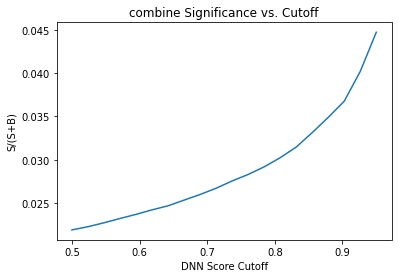

In [37]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/data/data_{year[i]}_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = 'combine')
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title('combine Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/data/data_{year[i]}_significance.png', format='png')
plt.show()

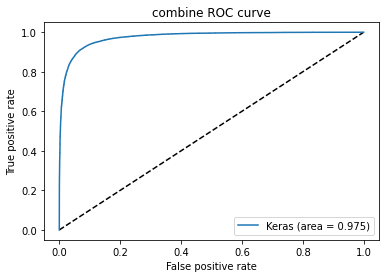

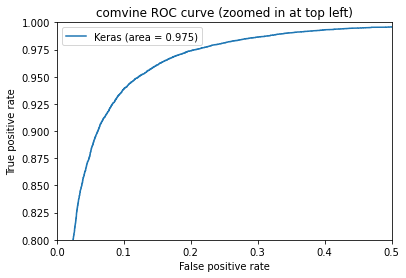

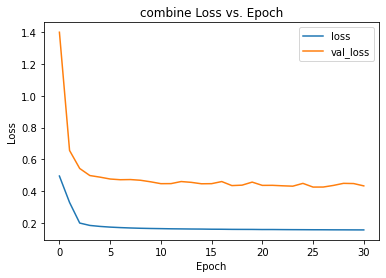

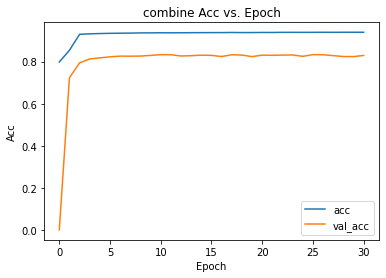

In [38]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,  label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('combine ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_{year[i]}_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,  label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('comvine ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_{year[i]}_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('combine Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_{year[i]}_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('combine Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_{year[i]}_epoch.png', format='png')
plt.show()

In [39]:
file = open(f'Efficiency/data/data_{year[i]}_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [40]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_{year[i]}_mass_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_{year[i]}_mass_jj_mass_sculpt_{samples[label]}_1')

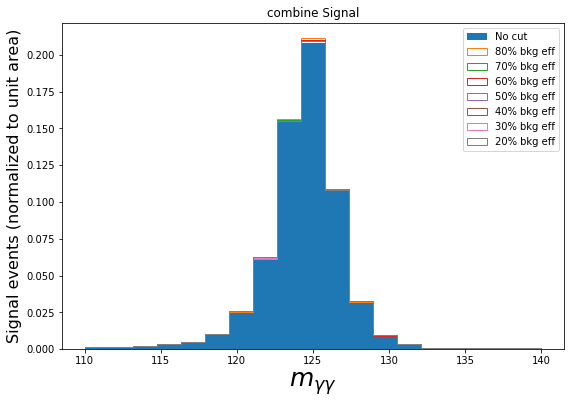

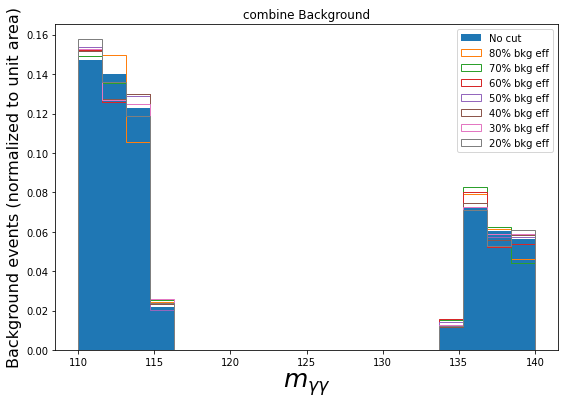

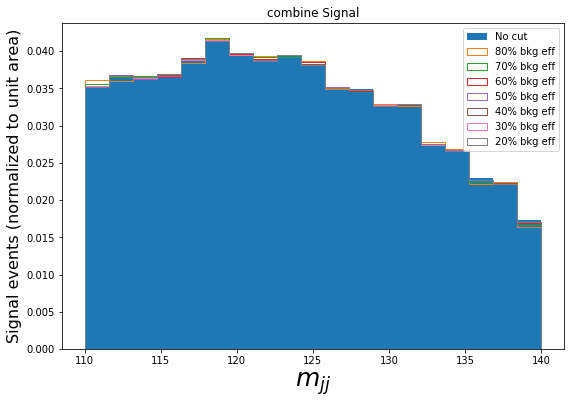

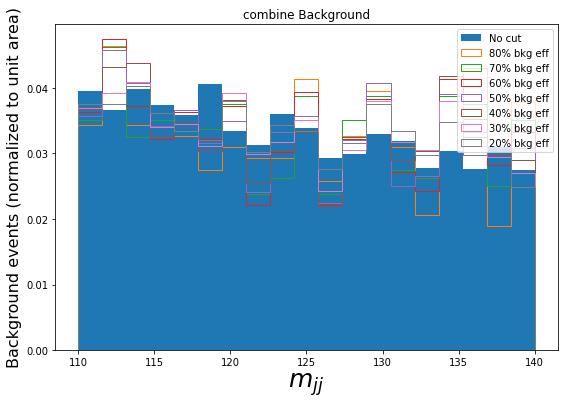

In [41]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 29, 27, 31, 32)
#bkg
check_mass_gg(0, test_all, 29, 27, 31, 32)

#signal
check_mass_jj(1, test_all, 28, 27, 31, 32)
#bkg
check_mass_jj(0, test_all, 28, 27, 31, 32)

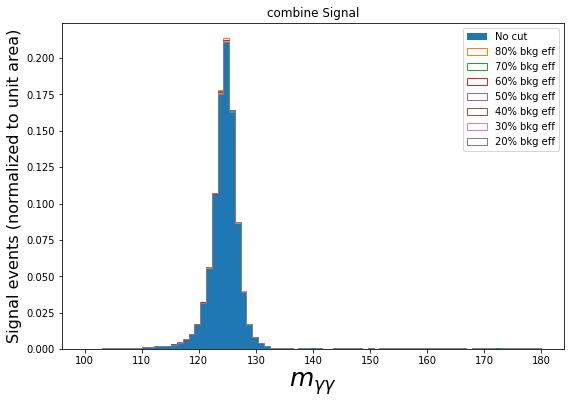

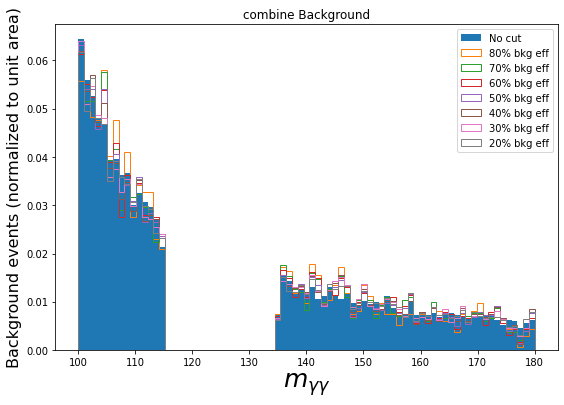

In [64]:
def check_mass_gg_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(100, 180, 80)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_fullrange_mass_gg_mass_sculpt_{samples[label]}_1')

#signal
check_mass_gg_full(1, test_all, 29, 27, 31, 32)
#bkg
check_mass_gg_full(0, test_all, 29, 27, 31, 32)

In [47]:
def mass_DNN_score(df, FPR_cut, mass_min, mass_max):
    df_range = df[df[b'diphoton_mass'] <= mass_max][df[b'diphoton_mass'] >= mass_min]
    #ms_vars = [b'diphoton_mass', b'DNN_score', b'genweight']
    #df_values = df_range[ms_vars]
    df_values = df_range.sort_values(by = [b'DNN score'])
    #print(df_values.columns)
    #print(df_values.head())
    #df_values.get(b'genweight')
    weight_array = df_values.loc[:, b'genweight'].values
    DNN_score_array = df_values.loc[:, b'DNN score'].values
    total_weight = np.sum(weight_array)
    tn_percent = 1 - FPR_cut
    tn_weight = total_weight * tn_percent
    weight_sum = 0
    for i in range(weight_array.shape[0]):
        weight_sum += weight_array[i]
        if weight_sum >= tn_weight:
            return DNN_score_array[i]

In [43]:
import numpy as np
bins_1 = np.linspace(100, 115, 16)
bins_2 = np.linspace(135, 180, 46)
bins = np.hstack((bins_1, bins_2))
print(bins)

[100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113.
 114. 115. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176. 177. 178. 179. 180.]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

[0.8608882, 0.91869503, 0.9029858, 0.8783751, 0.92374665, 0.9256199, 0.92794216, 0.853845, 0.89724135, 0.927937, 0.9167648, 0.89766943, 0.88758254, 0.87602586, 0.8856809]
[0.90738624, 0.9296655, 0.85105366, 0.87122273, 0.90737504, 0.9200307, 0.9016883, 0.9202846, 0.92363536, 0.9562421, 0.899766, 0.90263766, 0.9612053, 0.7819197, 0.87432665, 0.9369491, 0.87474036, 0.84141636, 0.87962425, 0.8447168, 0.84475976, 0.83674014, 0.8922651, 0.86064464, 0.85270566, 0.8921104, 0.9108059, 0.8883068, 0.92570335, 0.8985793, 0.8089446, 0.796711, 0.9238424, 0.8529644, 0.8969507, 0.92252564, 0.9182817, 0.8758257, 0.9312326, 0.9191494, 0.8362715, 0.81432337, 0.7266226, 0.8106664, 0.8437424]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


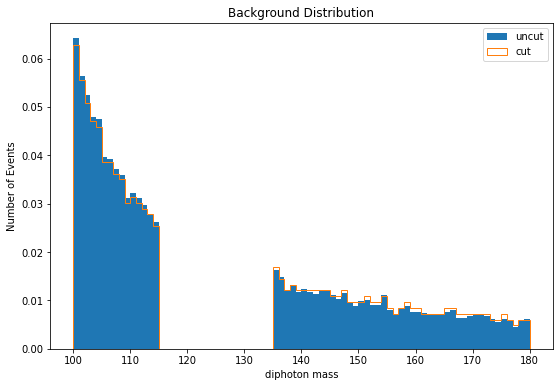

In [65]:
bins_1 = np.linspace(100, 115, 16)
bins_2 = np.linspace(135, 180, 46)
bins = np.hstack((bins_1, bins_2))
FPR = 5
result_bgd_df_sort = result_bgd_df.sort_values(by = [b'diphoton_mass'])
result_sig_df_sort = result_sig_df.sort_values(by = [b'diphoton_mass'])
DNN_cuts_1 = []
DNN_cuts_2 = []
for i in range(bins_1.shape[0] - 1):
    DNN_cuts_1.append(mass_DNN_score(result_bgd_df_sort, FPR / 100, bins_1[i], bins_1[i+1]))
for i in range(bins_2.shape[0] - 1):
    DNN_cuts_2.append(mass_DNN_score(result_bgd_df_sort, FPR / 100, bins_2[i], bins_2[i+1]))
    
print(DNN_cuts_1)
print(DNN_cuts_2)

bkd_cut = []
sig_cut = []

for i in range(bins_1.shape[0] - 1):
    mass_min = bins_1[i]
    mass_max = bins_1[i+1]
    df_bkg = result_bgd_df_sort[result_bgd_df_sort[b'diphoton_mass'] < mass_max][result_bgd_df_sort[b'diphoton_mass'] >= mass_min]
    #df_sig = result_sig_df_sort[result_sig_df_sort[b'diphoton_mass'] < mass_max][result_sig_df_sort[b'diphoton_mass'] >= mass_min]
    bkg_DNN = df_bkg.loc[:, b'DNN score'].values
    #sig_DNN = df_sig.loc[:, b'DNN score'].values
    for j in range(bkg_DNN.shape[0]):
        if bkg_DNN[j] >= DNN_cuts_1[i]:
            bkd_cut.append(1)
        else:
            bkd_cut.append(0)
    for k in range(sig_DNN.shape[0]):
        if sig_DNN[k] >= DNN_cuts_1[i]:
            sig_cut.append(1)
        else:
            sig_cut.append(0)
            
for i in range(bins_2.shape[0] - 1):
    mass_min = bins_2[i]
    mass_max = bins_2[i+1]
    df_bkg = result_bgd_df_sort[result_bgd_df_sort[b'diphoton_mass'] <= mass_max][result_bgd_df_sort[b'diphoton_mass'] > mass_min]
    #df_sig = result_sig_df_sort[result_sig_df_sort[b'diphoton_mass'] <= mass_max][result_sig_df_sort[b'diphoton_mass'] > mass_min]
    bkg_DNN = df_bkg.loc[:, b'DNN score'].values
    #sig_DNN = df_sig.loc[:, b'DNN score'].values
    for j in range(bkg_DNN.shape[0]):
        if bkg_DNN[j] >= DNN_cuts_2[i]:
            bkd_cut.append(1)
        else:
            bkd_cut.append(0)
    for k in range(sig_DNN.shape[0]):
        if sig_DNN[k] >= DNN_cuts_2[i]:
            sig_cut.append(1)
        else:
            sig_cut.append(0)
result_bgd_df_sort[b'mass_sculpt_cut'] = bkd_cut
#result_sig_df_sort[b'mass_sculpt_cut'] = sig_cut

final_bgd_df = result_bgd_df_sort[result_bgd_df_sort[b'mass_sculpt_cut'] == 1]
#final_sig_df = result_sig_df_sort[result_sig_df_sort[b'mass_sculpt_cut'] == 1]
# ori_sig_mass = result_sig_df_sort.loc[:, b'diphoton_mass'].values
# ori_sig_weight = result_sig_df_sort.loc[:, b'genweight'].values
# cut_sig_mass = final_sig_df.loc[:, b'diphoton_mass'].values
# cut_sig_weight = final_sig_df.loc[:, b'genweight'].values
ori_bgd_mass = result_bgd_df_sort.loc[:, b'diphoton_mass'].values
ori_bgd_weight = result_bgd_df_sort.loc[:, b'genweight'].values
cut_bgd_mass = final_bgd_df.loc[:, b'diphoton_mass'].values
cut_bgd_weight = final_bgd_df.loc[:, b'genweight'].values

# plt.figure()
# plt.hist(ori_sig_mass, bins = 80, range=(100, 180), weights = ori_sig_weight, label = 'uncut', density=True)
# plt.hist(cut_sig_mass, bins = 80, range=(100, 180), weights = cut_sig_weight, histtype='step', label = 'cut', density=True )
# plt.legend(loc = 'best')
# plt.xlabel('diphoton mass')
# plt.ylabel('Number of Events')
# plt.title('Signal Distribution')
# plt.savefig(fname = f'Mass_Sculpt_Plts/data/mgg_sig_cut_{FPR}')
# plt.show()

plt.figure(figsize = (9,6))
plt.hist(ori_bgd_mass, bins = 80, range=(100, 180), weights = ori_bgd_weight, label = 'uncut', density = True)
plt.hist(cut_bgd_mass, bins = 80, range=(100, 180), weights = cut_bgd_weight, histtype='step', label = 'cut', density = True )
plt.legend(loc = 'best')
plt.xlabel('diphoton mass')
plt.ylabel('Number of Events')
plt.title('Background Distribution')
plt.savefig(fname = f'Mass_Sculpt_Plts/data/mgg_bgd_cut_{FPR}')
plt.show()

In [193]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= 'combined background')
    plt.xlabel(hlf)
    plt.legend(loc='best')
    plt.savefig(fname = f'BackgroundVsSignal_Plts/data/data_{year[i]}_{hlf}')
    plt.close()

# 